## Library import & train.json 경로 설정

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
import cv2

from pycocotools.coco import COCO

In [2]:
data_dir = "/opt/ml/detection/dataset"
train_json = "train.json"

## json 파일 확인

In [3]:
def getDataFromJson(filepath):
    with open(filepath, "r") as f:
        return json.load(f)

In [4]:
json_path = os.path.join(data_dir, train_json)
train_data = getDataFromJson(json_path)

In [5]:
print(
    f"""
    keys : {train_data.keys()}\n
    info : {train_data['info']}\n
    length of info : {len(train_data['info'])}\n
    licenses : {train_data['licenses']}\n
    length of info : {len(train_data['info'])}\n
    images[0] : {train_data['images'][0]}\n
    length of images : {len(train_data['images'])}\n
    categories[0] : {train_data['categories'][0]}\n
    length of categories : {len(train_data['categories'])}\n
    annotations : {train_data['annotations'][0]}\n
    length of annotations : {len(train_data['annotations'])}"""
    )


    keys : dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

    info : {'year': 2021, 'version': '1.0', 'description': 'Recycle Trash', 'contributor': 'Upstage', 'url': None, 'date_created': '2021-02-02 01:10:00'}

    length of info : 6

    licenses : [{'id': 0, 'name': 'CC BY 4.0', 'url': 'https://creativecommons.org/licenses/by/4.0/deed.ast'}]

    length of info : 6

    images[0] : {'width': 1024, 'height': 1024, 'file_name': 'train/0000.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-26 14:44:23', 'id': 0}

    length of images : 4883

    categories[0] : {'id': 0, 'name': 'General trash', 'supercategory': 'General trash'}

    length of categories : 10

    annotations : {'image_id': 0, 'category_id': 0, 'area': 257301.66, 'bbox': [197.6, 193.7, 547.8, 469.7], 'iscrowd': 0, 'id': 0}

    length of annotations : 23144


In [6]:
train_data['images'][0] # images는 id 순서대로 리스트에 들어있음

{'width': 1024,
 'height': 1024,
 'file_name': 'train/0000.jpg',
 'license': 0,
 'flickr_url': None,
 'coco_url': None,
 'date_captured': '2020-12-26 14:44:23',
 'id': 0}

## 이미지 확인

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


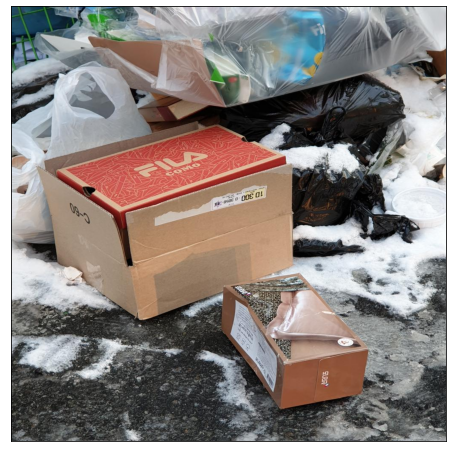

In [7]:
coco = COCO(json_path)

img_id = coco.getImgIds(imgIds=5)
img_info = coco.loadImgs(img_id)[0] # 리스트 안에 dict 형태로 담겨있는 구조

img = cv2.imread(os.path.join(data_dir, img_info['file_name']))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0

plt.figure(figsize=(8,8))
# 각 축에 좌표 안보이게 지워줌
plt.xticks([])
plt.yticks([])
plt.imshow(img)

## annotation 파일 전처리

In [8]:
def refineData(data):
	dataList = []
	for row in data['annotations']:
		imgId = row['image_id']
		imgRow = data['images'][imgId]
		categoryId = row["category_id"]
		categoryRow = data["categories"][categoryId]
		dataList.append({
			"image_id": imgId,
			"width": imgRow["width"],
			"height" : imgRow["height"],
			"file_name" : imgRow["file_name"],
			"category_id" : categoryId,
			"category_name" : categoryRow["name"],
			# "category_supercategory" : categoryRow["supercategory"], #똑같네...
			"area" : row["area"],
			"bbox" : row["bbox"],
			"iscrowd" : row["iscrowd"]
		})
	return dataList

In [9]:
refineData = refineData(train_data)

In [10]:
df = pd.DataFrame(refineData)

df.head()

,image_id,width,height,file_name,category_id,category_name,area,bbox,iscrowd
0,0,1024,1024,train/0000.jpg,0,General trash,257301.66,"[197.6, 193.7, 547.8, 469.7]",0
1,1,1024,1024,train/0001.jpg,3,Metal,10402.56,"[0.0, 407.4, 57.6, 180.6]",0
2,1,1024,1024,train/0001.jpg,7,Plastic bag,26259.36,"[0.0, 455.6, 144.6, 181.6]",0
3,1,1024,1024,train/0001.jpg,4,Glass,69096.17,"[722.3, 313.4, 274.3, 251.9]",0
4,1,1024,1024,train/0001.jpg,5,Plastic,24164.58,"[353.2, 671.0, 233.7, 103.4]",0


In [11]:
category_name = train_data['categories']
category_name = [c['name'] for c in category_name]
category_name

['General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

## 클래스 별 object 개수

<AxesSubplot:xlabel='category_id', ylabel='count'>

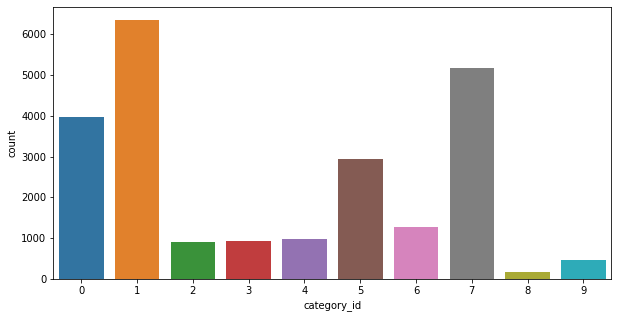

In [12]:
from collections import Counter

plt.rcParams["figure.figsize"] = (10,5)
cate_counter = Counter(df['category_id'])
cate_counter = list(cate_counter.items())
cate_counter.sort(key=lambda x: x[0])

obj_per_cate = pd.DataFrame([c[1] for c in cate_counter], columns = ['category_id'])
sns.countplot(x='category_id', data=df)

## 한 이미지 내에 등장하는 object 개수

In [13]:
from collections import Counter

image_counter = Counter(df['image_id'])
image_counter = list(image_counter.items()) # list 안에 tuple 인자 형태 (key, value)
image_counter.sort(key=lambda x: x[1], reverse=True)

print(image_counter[:10])
print(image_counter[-10:])

[(4197, 71), (946, 55), (4047, 52), (394, 48), (1955, 46), (2416, 46), (2981, 46), (1678, 44), (1797, 42), (4492, 42)]
[(4863, 1), (4864, 1), (4865, 1), (4868, 1), (4869, 1), (4870, 1), (4873, 1), (4874, 1), (4878, 1), (4880, 1)]


<AxesSubplot:xlabel='bbox_num', ylabel='count'>

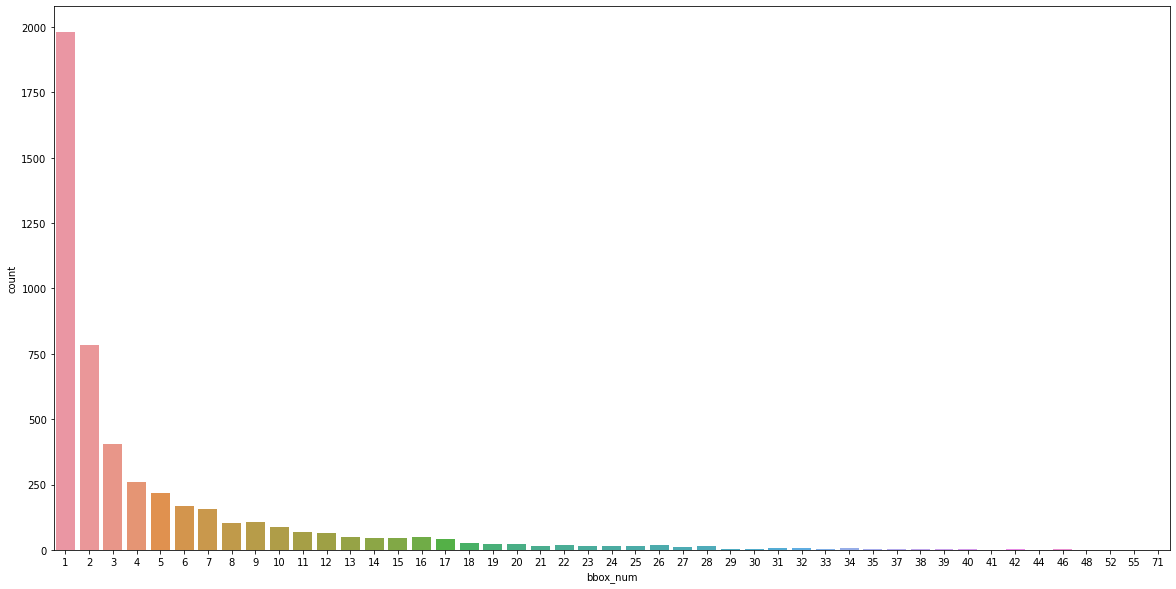

In [14]:
plt.rcParams["figure.figsize"] = (20, 10)
obj_num_in_img = pd.DataFrame(image_counter)
obj_num_in_img.columns = ['image_id', 'bbox_num']
sns.countplot(x='bbox_num', data=obj_num_in_img)

## 클래스 별 bbox 평균 사이즈 & 비율

In [15]:
for i in range(len(df)):
    print(type(df.iloc[i].bbox))
    break

<class 'list'>


In [16]:
cate_box_dict = dict()

for i in range(len(df)):
    now = df.iloc[i]

    if cate_box_dict.get(now['category_id']):
        cate_box_dict[now['category_id']].append((round(now['bbox'][2]), round(now['bbox'][3])))
    else:
        cate_box_dict[now['category_id']] = [(round(now['bbox'][2]), round(now['bbox'][3]))]

cate_boxsize_dict = dict()

for cate in cate_box_dict: # key값이 하나씩 나옴
    width = [box[0] for box in cate_box_dict[cate]]
    height = [box[1] for box in cate_box_dict[cate]]

    # round 함수에서 인자값 '1' : 소수점 첫자리까지 반올림 
    cate_boxsize_dict[cate] = (round(sum(width)/len(width)), round(sum(height)/len(height)))

cate_boxsize_dict

{0: (226, 215),
 3: (251, 257),
 7: (275, 301),
 4: (206, 272),
 5: (239, 231),
 2: (245, 220),
 6: (299, 252),
 1: (264, 237),
 9: (395, 392),
 8: (229, 215)}

In [17]:
list_cbd = list(cate_boxsize_dict.items())
list_cbd.sort(key=lambda x: x[0])

new_list_cbd = []

for i in range(len(list_cbd)):
    tmp = [list_cbd[i][0], category_name[i], list_cbd[i][1]]
    new_list_cbd.append(tmp)

bbox_avg_size_per_class = pd.DataFrame(new_list_cbd)
bbox_avg_size_per_class.columns = ['category_id', 'category_name', 'bbox_avg_size']

w_avg = np.array([w[1][0] for w in list_cbd]) / len(list_cbd)
h_avg = np.array([w[1][1] for w in list_cbd]) / len(list_cbd)

bbox_avg_size_per_class['bbox_avg_ratio'] = (w_avg / h_avg).round(2)
bbox_avg_size_per_class

,category_id,category_name,bbox_avg_size,bbox_avg_ratio
0,0,General trash,"(226, 215)",1.05
1,1,Paper,"(264, 237)",1.11
2,2,Paper pack,"(245, 220)",1.11
3,3,Metal,"(251, 257)",0.98
4,4,Glass,"(206, 272)",0.76
5,5,Plastic,"(239, 231)",1.03
6,6,Styrofoam,"(299, 252)",1.19
7,7,Plastic bag,"(275, 301)",0.91
8,8,Battery,"(229, 215)",1.07
9,9,Clothing,"(395, 392)",1.01


In [18]:
print(f"전체 bbox 평균 ratio : {bbox_avg_size_per_class['bbox_avg_ratio'].mean() : 0.2f}")

전체 bbox 평균 ratio :  1.02


## 전체 bbox scale

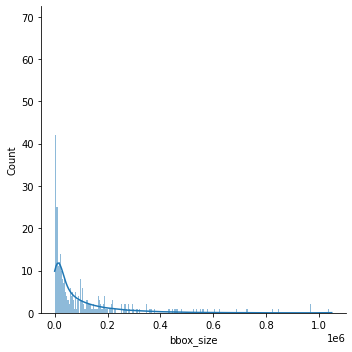

In [19]:
plt.rcParams["figure.figsize"] = (100,70)
all_bbox_scale = pd.DataFrame(list(df['area']), columns=['bbox_size'])
sns.displot(all_bbox_scale, x="bbox_size", kde=True, bins=20000)

## 전체 bbox ratio

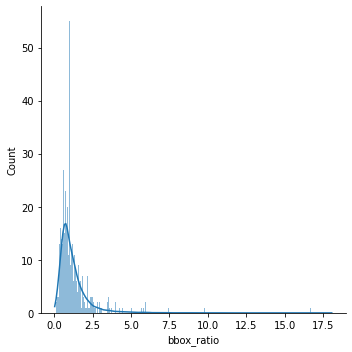

In [20]:
plt.rcParams["figure.figsize"] = (100,70)

bbox_ratio = []
for i in range(len(df)):
    now_box = df.iloc[i]['bbox']
    bbox_ratio.append(now_box[3] / now_box[2])

all_bbox_ratio = pd.DataFrame(bbox_ratio, columns=['bbox_ratio'])
sns.displot(all_bbox_ratio, x='bbox_ratio', kde=True, bins=20000)

## box 친 이미지 보기

In [39]:
from PIL import Image, ImageDraw, ImageFont
import random
def getPILImage(imageId, isTest=False):
	firstName = "/opt/ml/detection/dataset/train"
	if isTest:
		firstName = "/opt/ml/detection/dataset/test"

	fileName = f"{imageId:04}.jpg"

	imagePath = os.path.join(firstName, fileName)
	return Image.open(imagePath)

def drawBboxInImage(img, bbox_cate, bbox):
	draw = ImageDraw.Draw(img)
	for categoryName, bbox in zip(bbox_cate, bbox):

		x1, y1, width, length = bbox
		draw.rectangle(((x1,y1),(x1+width,y1+length)),width=3 ,outline=(random.randint(0,255),random.randint(0,255),random.randint(0,255)))

		imageFont = ImageFont.load_default()
		text = categoryName
		text_width, text_height = imageFont.getsize(text)
		draw.rectangle(((x1, y1 - text_height), (x1 + text_width, y1)), fill=(0, 0, 0))
		draw.text((x1, y1 - text_height), text, font=imageFont, fill=(255, 255, 255))

	return img

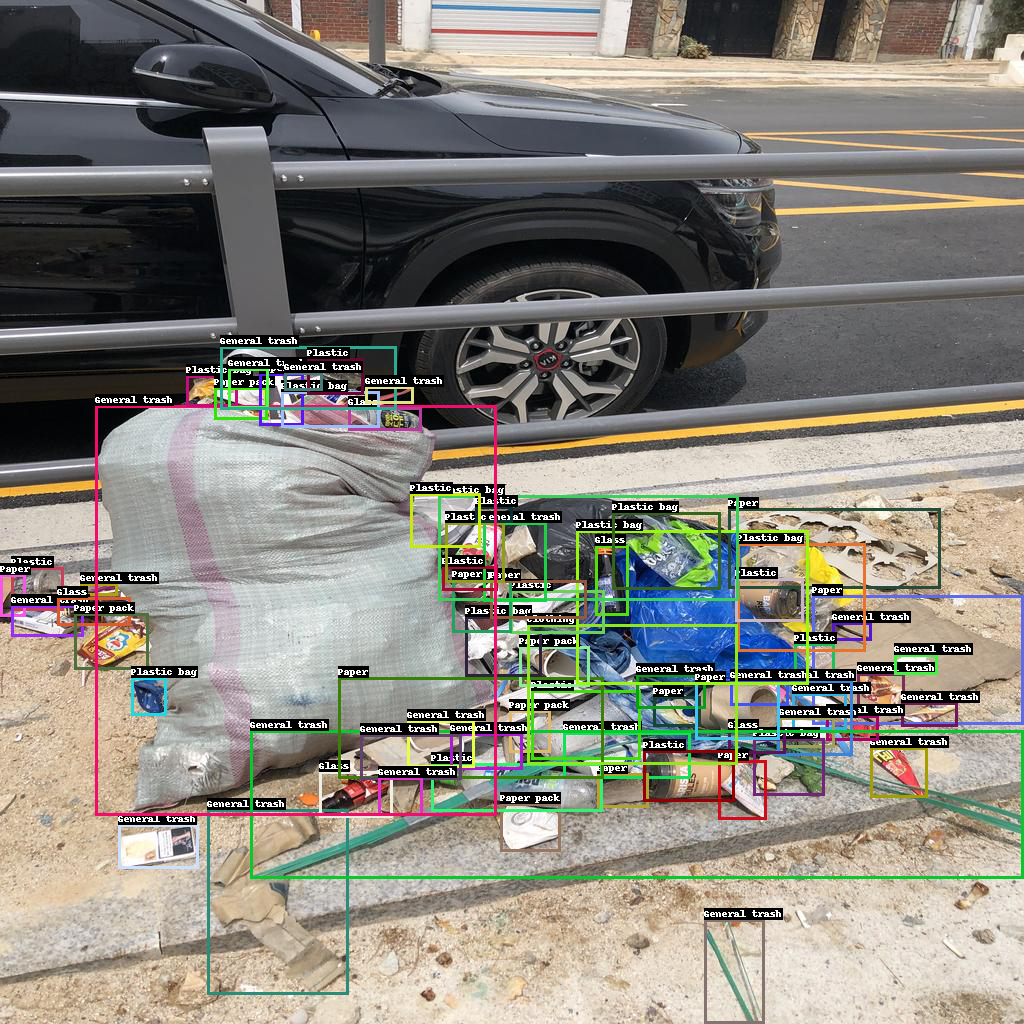

In [40]:
imageId = 4197 # 여기 바꿔서 확인해보기!
bbox_cate = list(df[df['image_id'] == imageId]['category_name'])
bbox = list(df[df['image_id'] == imageId]['bbox'])
img = getPILImage(imageId)
imgs = drawBboxInImage(img, bbox_cate, bbox)

imgs